# How many stars will I give? Predicting ratings of Amazon reviews

----------------
## Purpose
Many product reviews (from other platforms than Amazon) are not accompanied by a scale rating system, consisting only of a textual evaluation. In this case, it becomes daunting and time-consuming to compare different products in order to eventually make a choice between them. Therefore, models able to predict the user rating from the text review are critically important. Getting an overall sense of a textual review could in turn improve consumer experience. Also, it can help business to increase sales, and improve the product by understanding customers' needs and pain-points.

The purpose of this project is to develop models that are able to predict the user rating from the text review. While our model is built to work with any kind of product, the review dataset provided by Amazon only includes Clothing and Shoes  reviews.
 
## Data-Source
Amazon product data:  http://jmcauley.ucsd.edu/data/amazon/

## Sample review:
    "reviewerID": "A2SUAM1J3GNN3B",  
    "asin": "0000013714",  
    "reviewerName": "J. McDonald",  
    "helpful": [2, 3],  
    "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  
    "overall": 5.0,  
    "summary": "Heavenly Highway Hymns",  
    "unixReviewTime": 1252800000,  
    "reviewTime": "09 13, 2009"  

----------------
## I. Preparing Amazon dataset

In [1]:
##########################################
## 1.1 IMPORT DATA IN PANDAS
##########################################
import pandas as pd

review_df = pd.read_json('Amazon_reviews/Clothing_Shoes_and_Jewelry_5.json', orient='records', lines=True)

In [2]:
##########################################
## 1.2 CHECK DATA IN PANDAS
##########################################

# change column name 
review_df = review_df.rename(columns={'overall': 'Rating'})

print ("Total data:", str(review_df.shape))
review_df.head()

Total data: (278677, 9)


,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


## II. Preliminary Analysis

In [3]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(review_df)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(review_df.reviewerID.unique()))
reviewer_prop = float(len(review_df.reviewerID.unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(review_df.asin.unique()))
product_prop = float(len(review_df.asin.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(review_df.Rating.mean(),3))

print ("================================================")

Number of reviews:  278677

Number of unique reviewers:  39387
Prop of unique reviewers:  0.141

Number of unique products:  23033
Prop of unique products:  0.083

Average rating score:  4.245


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

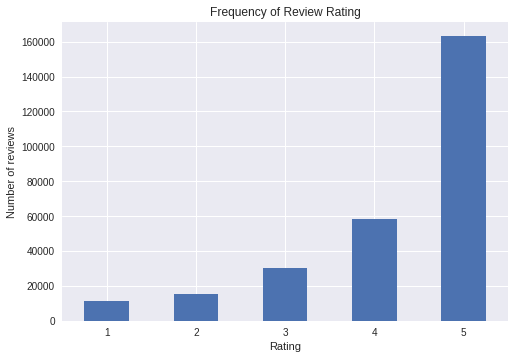

In [4]:
##########################################
## 2.2 DISTRIBUTION OF RATING SCORE
########################################## 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

review_df.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

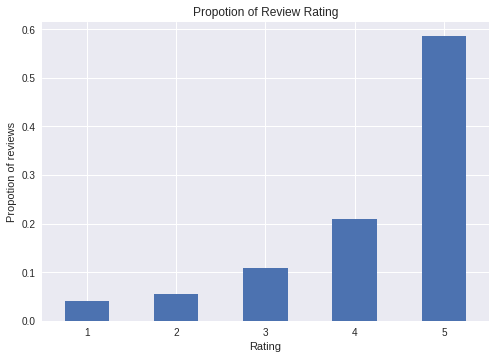

In [5]:
##########################################
## 2.3 DISTRIBUTION OF RATING PROPOTION
########################################## 

(review_df.groupby('Rating').size()/total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

In [6]:
######################
## 2.4 SUBSET DATA
######################

from datetime import datetime
def toDate(dt_str):
    return datetime.strptime(dt_str, '%m %d, %Y')

## select review time before 2012
dt_year = toDate('01 01, 2012')
review_df['reviewDate'] = review_df.reviewTime.apply(toDate)
sub_df = review_df[review_df.reviewDate < dt_year]
sub_total = len(sub_df)
print (sub_total)

16434


In [7]:
class_counts = sub_df.groupby('Rating').size()
class_counts

Rating
1      690
2      861
3     1518
4     3363
5    10002
dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

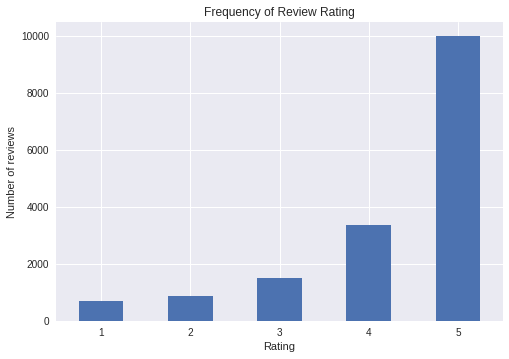

In [8]:
sub_df.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

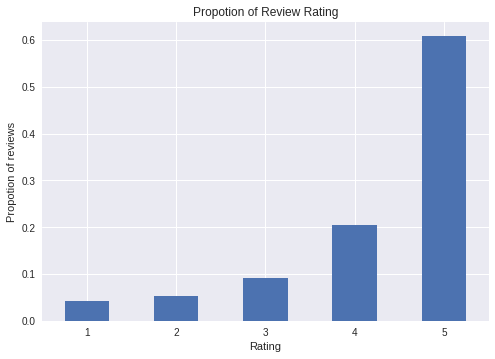

In [9]:
(sub_df.groupby('Rating').size()/sub_total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

## III. Pre-processing —— Text Normalization (Text Wrangling)
Text normalization is defined as a process that consists of a series of steps that should be followed to wrangle, clean, and standardize textual data into a form that
could be consumed by other NLP and analytics systems and applications as input. Besides tokenization, various other techniques include cleaning text, case conversion, correcting spellings,
removing stopwords and other unnecessary terms, stemming, and lemmatization. Text normalization is also often called text cleansing or wrangling.  

Below are various techniques used in the process of text normalization:
* __Cleaning Text__
* __Tokenizing Text__
* __Removing Special Characters__
* __Expanding Contractions__
* __Case Conversions__
* __Removing Stopwords__
* __Correcting Words__
* __Stemming__
* __Lemmatization__

In [10]:
import nltk
import re
import string

In [11]:
sdf = sub_df.copy()
sdf.index = range(sub_total)
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewDate
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800,2011-02-12
1,0000031887,"[0, 0]",5,Purchased this tutu for my granddaughter's fir...,"11 12, 2011",A391EXIT5TFP72,Lisbeth Starr,Wonderful tutu!,1321056000,2011-11-12
2,1608299953,"[201, 205]",4,"The product itself is five stars, however the ...","12 4, 2011",A3INPLAFCMRI3I,Cheryl,4 stars BUT beware...,1322956800,2011-12-04
3,1608299953,"[5, 6]",4,The first question was which computers to inst...,"09 21, 2010",A3NHUQ33CFH3VM,Citizen John,Intense way to learn,1285027200,2010-09-21
4,1608299953,"[11, 13]",5,"Okay, I admit it. I'm one of the millions of A...","06 16, 2011",A253TILLU81VZK,D. Connelly,Helped me actually get an A in a foreign langu...,1308182400,2011-06-16


### 1. Expanding Contractions
Contractions are shortened version of words or syllables. They exist in either written or spoken forms. Shortened versions of existing words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. 

By nature, contractions do pose a problem for NLP and text analytics because, to start with, we have a special apostrophe character in the word. Ideally, we can have a proper mapping for contractions and their corresponding expansions and then use it to expand all the contractions in our text. 

In [12]:
from contractions import CONTRACTION_MAP

# Define function to expand contractions
def expand_contractions(text):
    contractions_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match)\
                        if CONTRACTION_MAP.get(match)\
                        else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### 2. Removing Special Characters
One important task in text normalization involves removing unnecessary and *special characters*. These may be special symbols or even punctuation that occurs in sentences. This step is often performed before or after tokenization. The main reason for doing so is because often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML.

In [13]:
# Define the function to remove special characters
def remove_characters(text):
    text = text.strip()
    PATTERN = '[^a-zA-Z ]' # only extract alpha characters
    filtered_text = re.sub(PATTERN, '', text)
    return filtered_text

### 3. Tokenizing Text
Tokenization can be defined as the process of breaking down or splitting textual data into smaller meaningful components called tokens.  

**Sentence tokenization** is the process of splitting a text corpus into sentences that act as the first level of tokens which the corpus is comprised of. This is also known as sentence segmentation , because we try to segment the text into meaningful sentences.  

**Word tokenization** is the process of splitting or segmenting sentences into their constituent words. A sentence is a collection of words, and with tokenization we essentially split a sentence into a list of words that can be used to reconstruct the sentence.  

In [14]:
# Define the tokenization function
def tokenize_text(text):
    word_tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in word_tokens]
    return tokens

### 4. Removing Stopwords
*Stopwords* are words that have little or no significance. They are usually removed from text during processing so as to retain words having maximum significance and context. Stopwords are usually words that end up occurring the most if you aggregated any corpus of text based on singular tokens and checked their frequencies. Words like a, the , me , and so on are stopwords.

In [15]:
from nltk.corpus import stopwords
# In Python, searching a set is much faster than searching a list, 
# so convert the stop words to a set
stopword_list = set(stopwords.words("english"))

# Define function to remove stopwords
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

### 5. Correcting Words
One of the main challenges faced in text normalization is the presence of incorrect words in the text. The definition of incorrect here covers words that have spelling mistakes as well as words with several letters repeated that do not contribute much to its overall significance.

**5.1 Correcting Repeating Characters**

In [16]:
from nltk.corpus import wordnet

# Define function to remove repeated characters
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word

    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

**5.2 Correcting Spellings**

In [17]:
from collections import Counter

# Generate a map of frequently occurring words in English and their counts
"""
The input corpus we use is a file containing several books from the Gutenberg corpus and also 
a list of most frequent words from Wiktionary and the British National Corpus. You can find 
the file under the name big.txt or download it from http://norvig.com/big.txt and use it.
"""
def tokens(text):
    """
    Get all words from the corpus
    """
    return re.findall('[a-z]+', text.lower())

WORDS = tokens(open('big.txt').read())
WORD_COUNTS = Counter(WORDS)

In [18]:
# Define functions that compute sets of words that are one and two edits away from input word.
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [19]:
# Define function that returns a subset of words from our candidate set of words obtained from 
# the edit functions, based on whether they occur in our vocabulary dictionary WORD_COUNTS.
# This gives us a list of valid words from our set of candidate words.
def known(words): 
    "The subset of `words` that appear in the dictionary of WORD_COUNTS."
    return set(w for w in words if w in WORD_COUNTS)

In [20]:
# Define function to correct words
def correct(words):
    # Get the best correct spellings for the input words
    def candidates(word): 
        # Generate possible spelling corrections for word.
        # Priority is for edit distance 0, then 1, then 2, else defaults to the input word itself.
        candidates = known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
        return candidates
    
    corrected_words = [max(candidates(word), key=WORD_COUNTS.get) for word in words]
    return corrected_words

### 6. Lemmatization
The process of lemmatization is to remove word affixes to get to a base form of the word. The base form is also known as the root word, or the lemma, will always be present in the dictionary.

In [21]:
import spacy
nlp = spacy.load("en")

In [22]:
# Define function for Lemmatization
def Lemmatize_tokens(tokens):
    doc = ' '.join(tokens)
    Lemmatized_tokens = [token.lemma_ for token in nlp(doc)]
    return Lemmatized_tokens

### 7. Text Normalization

In [23]:
def normalize_corpus(corpus):
    normalized_corpus = []    
    for text in corpus:
        text = text.lower()
        text = expand_contractions(text)
        text = remove_characters(text)
        tokens = tokenize_text(text)
        tokens = remove_stopwords(tokens)
        tokens = remove_repeated_characters(tokens)
        tokens = correct(tokens)
        tokens = Lemmatize_tokens(tokens)
        text = ' '.join(tokens)
        normalized_corpus.append(text)
                    
    return normalized_corpus

In [24]:
# Normalize reviewText
sdf = sdf.assign(Norm_reviewText = normalize_corpus(sdf.reviewText))

In [25]:
# Normalize summary
sdf = sdf.assign(Norm_summary = normalize_corpus(sdf.summary))

In [26]:
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewDate,Norm_reviewText,Norm_summary
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800,2011-02-12,great tut really great price look cheap glad l...,great tut cheaply make
1,0000031887,"[0, 0]",5,Purchased this tutu for my granddaughter's fir...,"11 12, 2011",A391EXIT5TFP72,Lisbeth Starr,Wonderful tutu!,1321056000,2011-11-12,purchase tut granddaughter first birthday fit ...,wonderful tut
2,1608299953,"[201, 205]",4,"The product itself is five stars, however the ...","12 4, 2011",A3INPLAFCMRI3I,Cheryl,4 stars BUT beware...,1322956800,2011-12-04,product five star however description faulty r...,star beware
3,1608299953,"[5, 6]",4,The first question was which computers to inst...,"09 21, 2010",A3NHUQ33CFH3VM,Citizen John,Intense way to learn,1285027200,2010-09-21,first question computer install program rise s...,intense way learn
4,1608299953,"[11, 13]",5,"Okay, I admit it. I'm one of the millions of A...","06 16, 2011",A253TILLU81VZK,D. Connelly,Helped me actually get an A in a foreign langu...,1308182400,2011-06-16,okay admit one million american passively stru...,help actually get foreign language class


## IV. Feature Engineering

In [27]:
import pandas as pd
import numpy as np

In [28]:
#########################
## SUBSET DATA FOR TEST
#########################

## select review time after Jul.15 2014
dt_year = toDate('07 15, 2014')
new_df = review_df[review_df.reviewDate > dt_year]
new_total = len(new_df)
print (new_total)

749


In [29]:
ndf = new_df.copy()
ndf.index = range(new_total)
ndf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewDate
0,B00022JPNE,"[0, 0]",4,I wear a size 34 waist and based on the manufa...,"07 16, 2014",A9NJQ4KOTWI4V,NaN,nice but tight,1405468800,2014-07-16
1,B00023JMYU,"[0, 0]",1,start chanfin colors after one wear,"07 20, 2014",A1O0GKFCQ0OP9I,NaN,One Star,1405814400,2014-07-20
2,B0002NYQN2,"[0, 0]",5,Arrived as promised... hard to find PLAIN navy...,"07 21, 2014",A2X616HR0FF4KK,"Gary Van Thorntonpatricia Logan ""pjlogan-thor...",ready for a workout!,1405900800,2014-07-21
3,B000NIAH8E,"[0, 0]",5,Great colorful and really cottonUse this as a ...,"07 16, 2014",AA91O96C1Z18W,NaN,Happy Camper with colorful head wrap,1405468800,2014-07-16
4,B000PBTTO2,"[0, 0]",5,These are wonderful pants. They are a great fi...,"07 20, 2014",A31FXPO61IC3F8,Across the Pond,Dockers Men's Easy Khaki Slim Fit men's pant,1405814400,2014-07-20


In [30]:
# Normalize reviewText
ndf = ndf.assign(Norm_reviewText = normalize_corpus(ndf.reviewText))

In [31]:
# Normalize summary
ndf = ndf.assign(Norm_summary = normalize_corpus(ndf.summary))

In [32]:
# Define function to display feature names
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print (df)

### 1. Bag of Words Model

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range, max_features = 5000)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [34]:
bow_vectorizer, bow_features = bow_extractor(sdf.Norm_reviewText)
features_bow = bow_features.todense()
feature_names = bow_vectorizer.get_feature_names()
print (feature_names)

['ab', 'abdoman', 'ability', 'able', 'abolish', 'about', 'abrasion', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbent', 'absorption', 'abuse', 'ac', 'accent', 'accept', 'acceptable', 'access', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'accommodate', 'accompany', 'accomplish', 'accord', 'accordingly', 'account', 'accuracy', 'accurate', 'accurately', 'accustomed', 'ache', 'achieve', 'achille', 'acid', 'acorn', 'acquire', 'acre', 'across', 'acrylic', 'act', 'action', 'activate', 'active', 'activity', 'actual', 'actually', 'acuteness', 'ad', 'adapt', 'add', 'added', 'addition', 'additional', 'address', 'adequate', 'adequately', 'adhere', 'adhesive', 'adjust', 'adjustable', 'adjusted', 'adjustment', 'admire', 'admit', 'admittedly', 'adorable', 'adore', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advertise', 'advertised', 'advertising', 'advice', 'advise', 'aerobe', 'aerobic', 'aerosole', 'aesthetic', 'aesthetically', 'affect', 

In [35]:
display_features(features_bow[5000:5010], feature_names)

   ab  abdoman  ability  able  abolish  about  abrasion  absent  absolute  \
0   0        0        0     0        0      0         0       0         0   
1   0        0        0     0        0      0         0       0         0   
2   0        0        0     0        0      0         0       0         0   
3   0        0        0     0        0      0         0       0         0   
4   0        0        0     0        0      0         0       0         0   
5   0        0        0     0        0      0         0       0         0   
6   0        0        0     0        0      0         0       0         0   
7   0        0        0     0        0      0         0       0         0   
8   0        0        0     0        0      0         0       0         0   
9   0        0        0     0        0      0         0       0         0   

   absolutely  ...   yield  york  young  youth  zapata  zenger  zero  zip  \
0           0  ...       0     0      0      0       0       0     0    0  

In [ ]:
# sdf = sdf.assign(features_bow = features_bow)

In [36]:
# extract features from new document using built vectorizer
new_features = bow_vectorizer.transform(ndf.Norm_reviewText)
new_features_bow = new_features.todense()

In [37]:
display_features(new_features_bow[0:10], feature_names)

   ab  abdoman  ability  able  abolish  about  abrasion  absent  absolute  \
0   0        0        0     0        0      0         0       0         0   
1   0        0        0     0        0      0         0       0         0   
2   0        0        0     0        0      0         0       0         0   
3   0        0        0     0        0      0         0       0         0   
4   0        0        0     0        0      0         0       0         0   
5   0        0        0     0        0      0         0       0         0   
6   0        0        0     0        0      0         0       0         0   
7   0        0        1     0        0      0         0       0         0   
8   0        0        0     0        0      0         0       0         0   
9   0        0        0     0        0      0         0       0         0   

   absolutely  ...   yield  york  young  youth  zapata  zenger  zero  zip  \
0           0  ...       0     0      0      0       0       0     0    0  

### 2. TF-IDF Model 
TF-IDF stands for Term Frequency-Inverse Document Frequency, a combination of two metrics: term frequency and inverse document frequency.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define function to directly compute the tfidf-based feature vectors for documents from the raw documents.
def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range,
                                 max_features = 5000)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [39]:
# get training corpus feature vectors
tfidf_vectorizer, tdidf_features = tfidf_extractor(sdf.Norm_reviewText)
features = tdidf_features.todense()
features_tfidf = np.round(features, 2)

In [40]:
features.shape

(16434, 5000)

In [41]:
feature_names = tfidf_vectorizer.get_feature_names()
display_features(features_tfidf[0:10], feature_names)

    ab  abdoman  ability  able  abolish  about  abrasion  absent  absolute  \
0  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
1  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
2  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
3  0.0      0.0      0.0  0.06      0.0    0.0       0.0     0.0       0.0   
4  0.0      0.0      0.0  0.10      0.0    0.0       0.0     0.0       0.0   
5  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
6  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
7  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
8  0.0      0.0      0.0  0.00      0.0    0.0       0.0     0.0       0.0   
9  0.0      0.0      0.0  0.19      0.0    0.0       0.0     0.0       0.0   

   absolutely  ...   yield  york  young  youth  zapata  zenger  zero  zip  \
0         0.0  ...     0.0   0.0    0.0    0.0     0.0     0.0  

In [42]:
# get tfidf feature vector for the new document
new_features = tfidf_vectorizer.transform(sdf.Norm_reviewText)
new_features_tfidf = new_features.todense()

In [43]:
display_features(new_features_tfidf[0:10], feature_names)

    ab  abdoman  ability      able  abolish  about  abrasion  absent  \
0  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
1  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
2  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
3  0.0      0.0      0.0  0.060399      0.0    0.0       0.0     0.0   
4  0.0      0.0      0.0  0.096016      0.0    0.0       0.0     0.0   
5  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
6  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
7  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
8  0.0      0.0      0.0  0.000000      0.0    0.0       0.0     0.0   
9  0.0      0.0      0.0  0.193265      0.0    0.0       0.0     0.0   

   absolute  absolutely  ...   yield  york  young  youth  zapata  zenger  \
0       0.0         0.0  ...     0.0   0.0    0.0    0.0     0.0     0.0   
1       0.0         0.0  ...     0.0   0.0    0.0    0.

### 3. Averaged Word Vectors

In [44]:
import numpy as np    

# Define function to average word vectors for a text document
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [53]:
# Generalize above function for a corpus of documents  
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(sentence, model, vocabulary, num_features) for sentence in corpus]
    return np.array(features)

In [46]:
# tokenize reviewText
tokenized_reviewText = [nltk.word_tokenize(text) for text in sdf.Norm_reviewText]
tokenized_newReview = [nltk.word_tokenize(text) for text in ndf.Norm_reviewText]                        

In [54]:
import gensim

# build the word2vec model on our training corpus
model = gensim.models.Word2Vec(tokenized_reviewText, 
                               size=5000,
                               window=10,
                               min_count=2,
                               sample=1e-3)

In [55]:
# get averaged word vectors for our training CORPUS
avg_word_vec_features = averaged_word_vectorizer(corpus=tokenized_reviewText, model=model, num_features=5000)
print (np.round(avg_word_vec_features, 3))

[[-0.065  0.041 -0.042 ...,  0.073  0.002  0.019]
 [-0.203  0.056 -0.101 ...,  0.022  0.007  0.001]
 [-0.034  0.022 -0.048 ...,  0.018 -0.009  0.005]
 ..., 
 [-0.095  0.042 -0.114 ...,  0.021  0.009  0.035]
 [-0.002 -0.01  -0.04  ..., -0.003 -0.001  0.034]
 [-0.115 -0.014 -0.077 ..., -0.026  0.008  0.048]]


In [57]:
# get averaged word vectors for our test new_doc
new_avg_word_vec_features = averaged_word_vectorizer(corpus=tokenized_newReview, model=model, num_features=5000)
print (np.round(new_avg_word_vec_features, 3))

[[-0.086 -0.05   0.032 ...,  0.034  0.026  0.04 ]
 [-0.152  0.003 -0.036 ..., -0.062 -0.015  0.023]
 [-0.077 -0.016 -0.044 ...,  0.007 -0.005  0.016]
 ..., 
 [ 0.053 -0.029  0.054 ...,  0.009 -0.008  0.002]
 [ 0.052 -0.027  0.05  ...,  0.024  0.016  0.027]
 [ 0.    -0.004  0.004 ...,  0.01  -0.01  -0.006]]


### 4. TF-IDF Weighted Averaged Word Vectors

In [58]:
# Define function to compute tfidf weighted averaged word vector for a document
def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]    
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index2word)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector

In [59]:
# Generalize above function for a corpus of documents
def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features) 

In [60]:
# get tfidf weights and vocabulary from earlier results and compute result
corpus_tfidf = tdidf_features
vocab = tfidf_vectorizer.vocabulary_
wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(corpus=sdf.Norm_reviewText,
                                                                     tfidf_vectors=corpus_tfidf,
                                                                     tfidf_vocabulary=vocab,
                                                                     model=model, 
                                                                     num_features=5000)
print (np.round(wt_tfidf_word_vec_features, 3))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [63]:
# compute avgd word vector for test new_doc
new_wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(corpus=ndf.Norm_reviewText,
                                                                     tfidf_vectors=corpus_tfidf,
                                                                     tfidf_vocabulary=vocab,
                                                                     model=model, 
                                                                     num_features=5000)
print (np.round(new_wt_tfidf_word_vec_features, 3))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
